<a href="https://colab.research.google.com/github/99527xy/neural-network/blob/main/segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Objective**: Implement and analyze the performance of image segmentation techniques on a given dataset.

**Dataset**
Use a publicly available image dataset relevant to the course's focus, such as the [Oxford Pets dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) for animal segmentation or a custom dataset comprising various common objects for segmentation.

The dataset should include images with varying complexities to challenge the segmentation algorithms (e.g., different backgrounds, multiple objects per image).

**Tasks**
1. Exploratory Data Analysis: Visualize a subset of images from the dataset.
2. Analyze the challenges present in the dataset for segmentation (e.g., varied object sizes, overlapping objects).
3. Apply at least two segmentation techniques (e.g., thresholding, edge detection, clustering-based, graph-based, and/or a deep learning-based approach like U-Net for semantic segmentation).
4. Provide a brief explanation of each technique's principles and why it was chosen.

**Evaluation and Comparison**:

- Evaluate the segmentation results using appropriate metrics (e.g., Intersection over Union (IoU), Dice coefficient).
- Compare the effectiveness of the applied segmentation techniques on the dataset.

# Image segmentation

This tutorial focuses on the task of image segmentation, using a modified <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

## What is image segmentation?
So far you have seen image classification, where the task of the network is to assign a label or class to an input image. However, suppose you want to know where an object is located in the image, the shape of that object, which pixel belongs to which object, etc. In this case you will want to segment the image, i.e., each pixel of the image is given a label. Thus, the task of image segmentation is to train a neural network to output a pixel-wise mask of the image. This helps in understanding the image at a much lower level, i.e., the pixel level. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging to name a few.

The dataset that will be used for this tutorial is the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images, their corresponding labels, and pixel-wise masks. The masks are basically labels for each pixel. Each pixel is given one of three categories :

*   Class 1 : Pixel belonging to the pet.
*   Class 2 : Pixel bordering the pet.
*   Class 3 : None of the above/ Surrounding pixel.

For this problem, we select the Oxford-IIIT Pet Dataset as they are part of Tensorflow Dataset and are easy to obtained. We first do some initial setting in the following. Then we will download the dataset.

In [1]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install -U tfds-nightly
!pip install -U scikit-image

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-9fu8_7aq
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-9fu8_7aq
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1703207612.1461250479831370929614362828255168868146460245314-py3-none-any.whl size=301584 sha256=0fef39a9052ef2448c4a42ea2503c4ff54c9b7790afa865355667cf621d95a08
  Stored in directory: /tmp/pip-ephem-wheel-cache-3pzhd2yd/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 14.5 MB/s eta 0:00:00


In [2]:
import tensorflow as tf

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

## Download the Oxford-IIIT Pets dataset

We download the dataset here. The segmentation masks are included in version 3+.

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.L342C4_3.2.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.L342C4_3.2.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


The info of the dataset is shown in the following, we can see that the dataset contains totally 7349 images with built-in train and test sets. The number of classes in the dataset is 37 and it contains the segmentation mask for each dataset for training.

In [5]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir=PosixGPath('/tmp/tmpjynkyu1ktfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        '

Then we rescale the images to the range [-1,1] and decrease the masks to -1.

In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

We next resize the train and test sets to the size 128*128 and augment the train dataset by flipping the images.

In [7]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

We define a batch size of 64 and a buffer size of 1000 for creating batches of training and test datasets.

In [9]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [10]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

We split some of the test set into validation set and the rest as the new test set.

In [11]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = test.batch(BATCH_SIZE)

Let's take a look at an image example and it's correponding mask from the dataset.

In [12]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

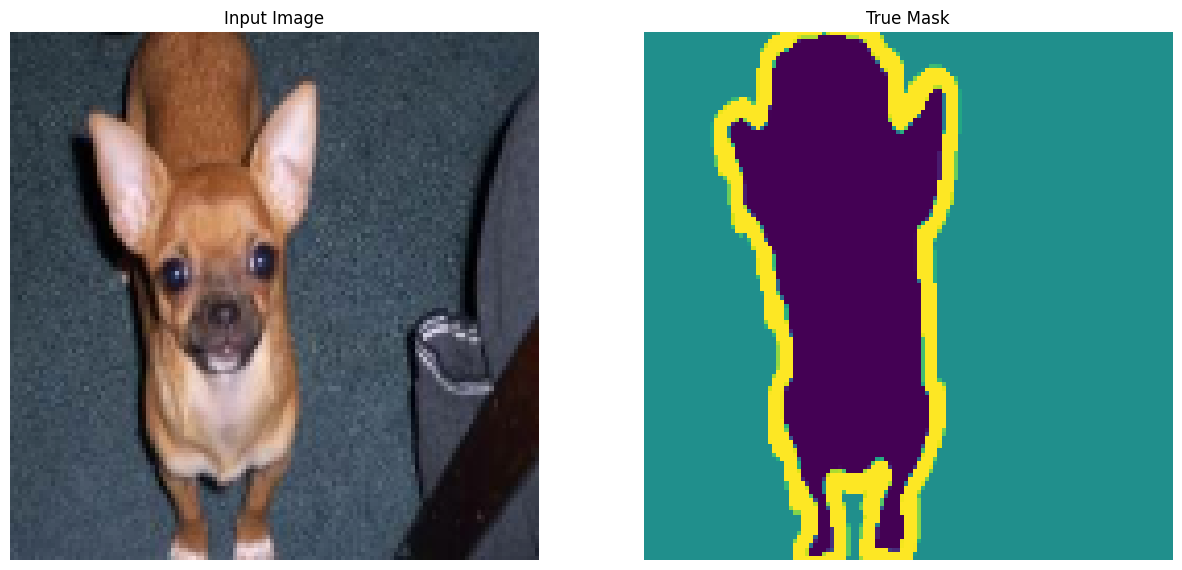

In [17]:
import numpy as np
sample_batch = next(iter(train_dataset))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])

In [18]:
import cv2
import numpy as np

In [19]:
sam = tf.keras.preprocessing.image.array_to_img(sample_image)

In [20]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from cycler import cycler
from PIL import Image, ImageEnhance

# Loads the image then enhances it
contrast = ImageEnhance.Contrast(sam)
img = contrast.enhance(2)
img = np.asarray(img)
r, g, b = cv2.split(img)
contrast = cv2.merge([b, g, r])
# Reads the enhanced image and converts it to grayscale, creates new file
gray_image = cv2.cvtColor(contrast, cv2.COLOR_BGR2GRAY) #there is a problem here

In [21]:
gray_image.shape

(128, 128)

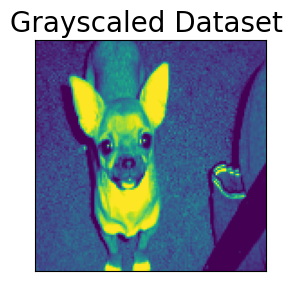

In [22]:
plt.figure(figsize=(3,3))
plt.xticks([])
plt.yticks([])
plt.imshow(gray_image)
plt.suptitle("Grayscaled Dataset", fontsize=20)
plt.show()

In [28]:
from skimage import data, segmentation, color
from skimage import graph
from matplotlib import pyplot as plt


img = contrast

labels1 = segmentation.slic(img, compactness=30, n_segments=400,
                            start_label=1)
out1 = color.label2rgb(labels1, img, kind='avg', bg_label=0)

g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)
out2 = color.label2rgb(labels2, img, kind='avg', bg_label=0)

fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))

ax[0].imshow(out1)
ax[1].imshow(out2)

for a in ax:
    a.axis('off')

plt.tight_layout()

AttributeError: module 'skimage.graph' has no attribute 'cut_normalized'

In [71]:
ret, thresh = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
marker = np.zeros_like(gray_image)
marker[thresh==255] = 255

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'


In [75]:
img = cv2.convertScaleAbs(contrast)

array([[[ 0, 23,  7],
        [ 0, 21,  0],
        [ 0,  0,  0],
        ...,
        [ 0, 73, 69],
        [ 0, 47, 37],
        [ 0, 37, 23]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0, 67, 51],
        [ 0, 53, 31],
        [ 0, 53,  1]],

       [[ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0, 49, 27],
        [ 0, 33,  0],
        [ 0,  5,  0]],

       ...,

       [[ 0, 23,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0, 55, 49],
        [ 0,  5,  0],
        [ 0, 25, 25]],

       [[ 0,  7,  0],
        [ 0, 11,  0],
        [ 0, 13,  0],
        ...,
        [ 0,  0,  0],
        [ 0,  0,  0],
        [ 0,  9,  0]],

       [[ 0,  9,  0],
        [ 0,  0,  0],
        [ 0,  0,  0],
        ...,
        [ 0,  0,  0],
        [ 0, 31, 15],
        [ 0,  0,  0]]], dtype=uint8)
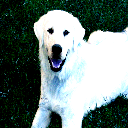

In [78]:
contrast

In [76]:
marker = cv2.watershed(img, marker)
img_copy = contrast.copy()
img_copy[marker == -1] = [255,0,0] # Boundary regions are marked as -1 in the marker image
cv2.imwrite('segmented_image.jpg', img_copy)
cv2.imshow('Segmented Image', img_copy)

error: OpenCV(4.8.0) /io/opencv/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'


In [63]:
edges = cv2.Canny(gray_image, 100, 200)

In [66]:
img_arr = []
img_arr.append(contrast)
thresh = [cv2.threshold(img, np.mean(img), 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)[1] for img in tqdm(gray_image)]

100%|██████████| 128/128 [00:00<00:00, 9397.68it/s]


In [67]:
edges = [cv2.dilate(cv2.Canny(img, 0, 255), None) for img in tqdm(thresh)]
masked = []
segmented = []
for i, img in tqdm(enumerate(edges)):

    cnt = sorted(cv2.findContours(gray_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
    mask = np.zeros((256,256), np.uint8)
    masked.append(cv2.drawContours(mask, [cnt],-1, 255, -1))
    dst = cv2.bitwise_and(img_arr[i], img_arr[i], mask=mask)
    segmented.append(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

100%|██████████| 128/128 [00:00<00:00, 3258.94it/s]
0it [00:00, ?it/s]


error: OpenCV(4.8.0) /io/opencv/modules/core/src/arithm.cpp:230: error: (-215:Assertion failed) (mtype == CV_8U || mtype == CV_8S) && _mask.sameSize(*psrc1) in function 'binary_op'


 The figure shows both image and the mask. From the figure we see that the mask contains a green background with a purple foreground and the object we need to segment is circled by a thick yellow line. Also we can see from the figure that some of the white areas of the dog are merged with the background. We can also see that in each photo, the size, species and the color of the animal is different, also, the background is different, which may bring lots of difficulty when we deal with the image segmentation.

 In the following, we select edge detection and U-Net method to handle this problem.


## Define the model
The first model we considered here is a modified U-Net model.

A U-Net consists of an encoder (downsampler) and decoder (upsampler). In-order to learn robust features, and reduce the number of trainable parameters, a pretrained model can be used as the encoder. We considered the MobileNetV2 model, whose intermediate outputs will be used, and the decoder will be the upsample block already implemented in TensorFlow Examples in the Pix2pix.
The reason to output three channels is because there are three possible labels for each pixel. Think of this as multi-classification where each pixel is being classified into three classes.

In [13]:
OUTPUT_CHANNELS = 3

As mentioned, the encoder will be a pretrained MobileNetV2 model which is prepared and ready to use in [tf.keras.applications](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications). The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [14]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples.

In [15]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [16]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model
Now, all that is left to do is to compile and train the model. The loss being used here is `losses.SparseCategoricalCrossentropy(from_logits=True)`. The reason to use this loss function is because the network is trying to assign each pixel a label, just like multi-class prediction. In the true segmentation mask, each pixel has either a {0,1,2}. The network here is outputting three channels. Essentially, each channel is trying to learn to predict a class, and `losses.SparseCategoricalCrossentropy(from_logits=True)` is the recommended loss for
such a scenario. Using the output of the network, the label assigned to the pixel is the channel with the highest value. This is what the create_mask function is doing.

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Have a quick look at the resulting model architecture:

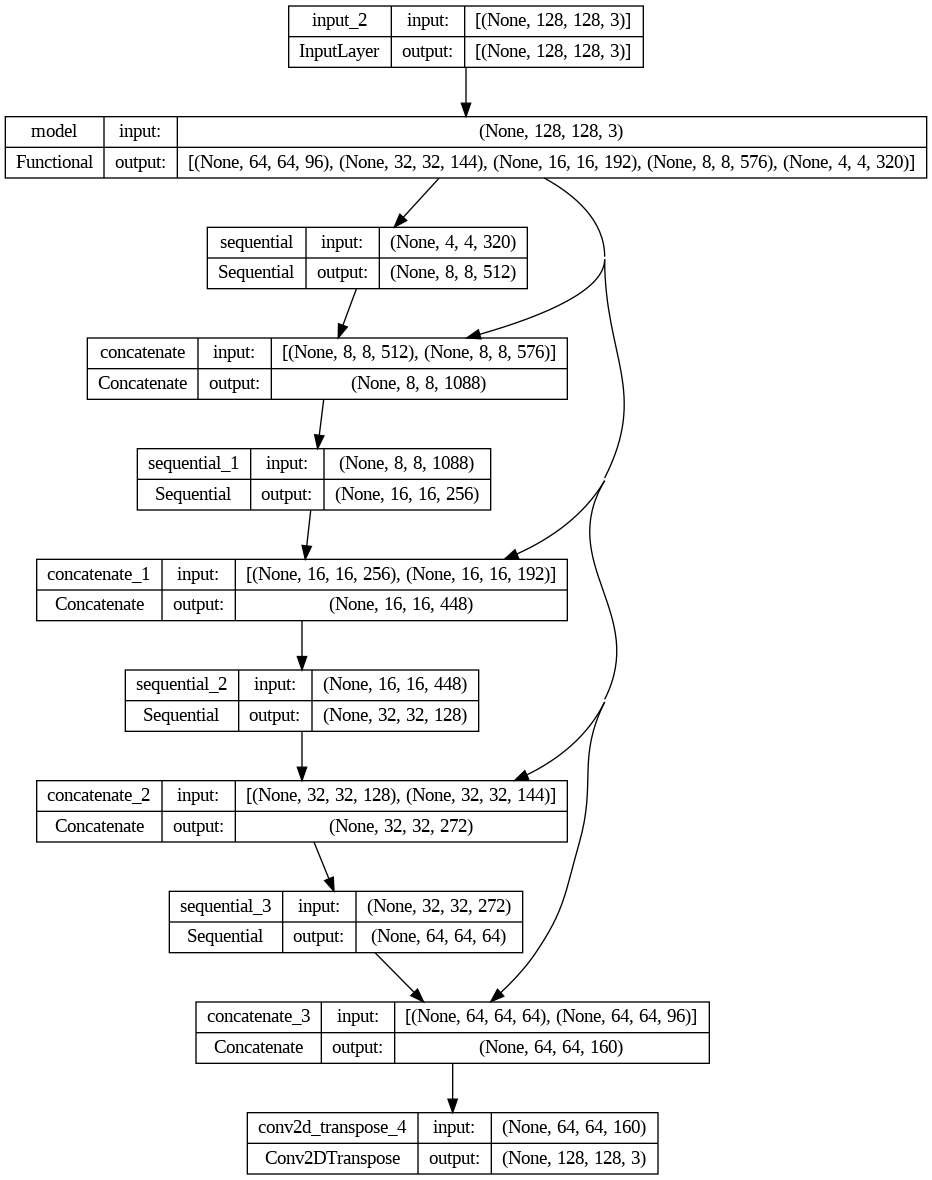

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


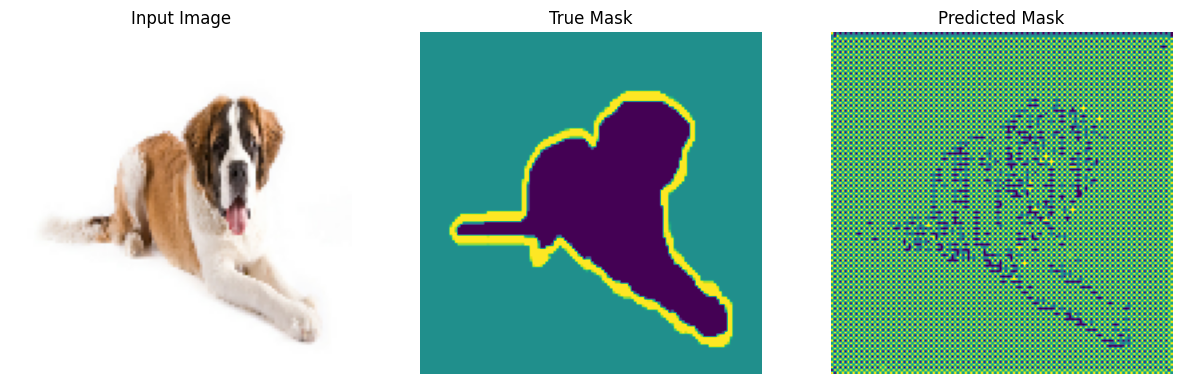

In [ ]:
show_predictions()

Let's observe how the model improves while it is training. To accomplish this task, a callback function is defined below.

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

1/1 [==============================] - 0s 66ms/step


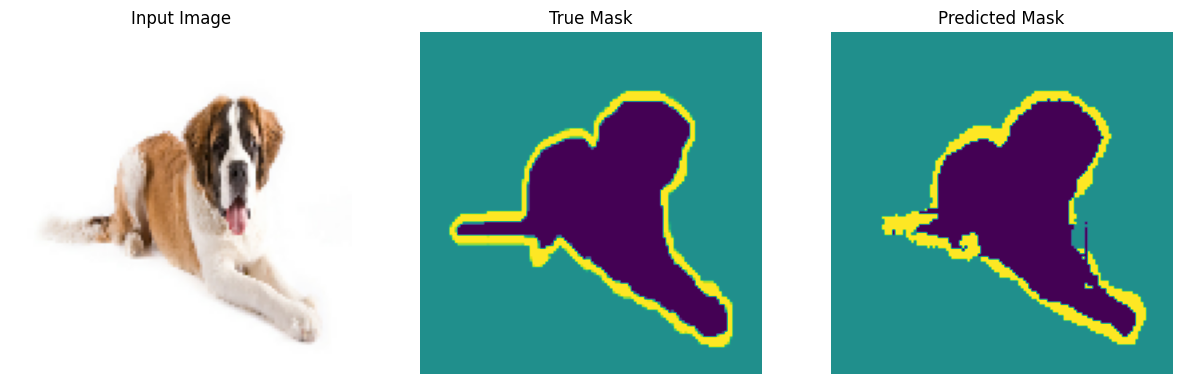


Sample Prediction after epoch 20

57/57 [==============================] - 372s 7s/step - loss: 0.1376 - accuracy: 0.9372 - val_loss: 0.3235 - val_accuracy: 0.8885


In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=validation_dataset,
                          callbacks=[DisplayCallback()])

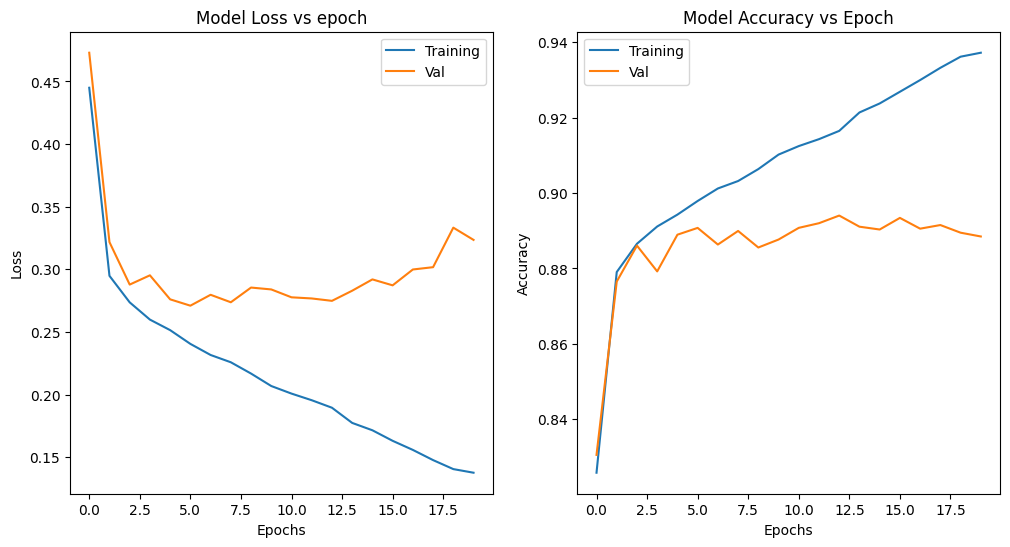

In [ ]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training')
plt.plot(model_history.history['val_loss'], label='Val')
plt.title('Model Loss vs epoch')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Training')
plt.plot(model_history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy vs Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()


We see from the curves that the after around epoch 15 the model begins to overfit. However we don not set the epochs too large the overfitting is acceptable. Thus we will use this model to make predictions and show some of the predictions in the following.

## Make predictions

Let's make some predictions. In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

2/2 [==============================] - 3s 1s/step


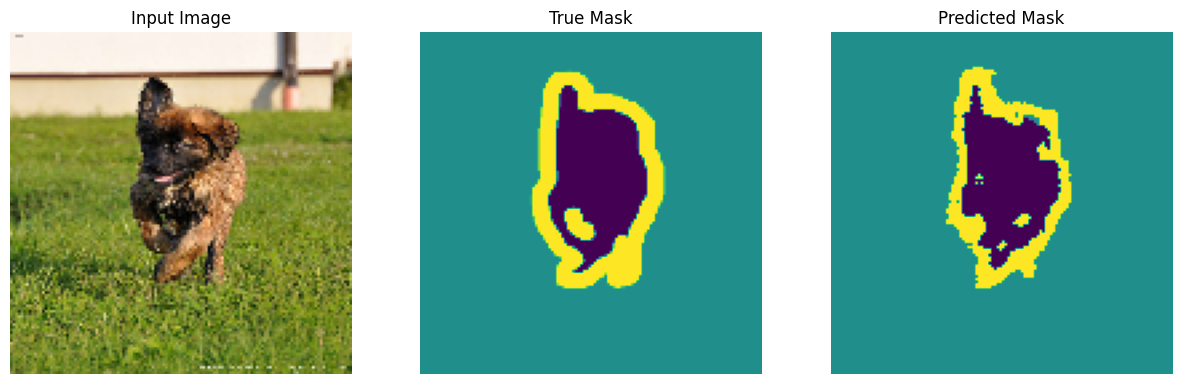

2/2 [==============================] - 4s 2s/step


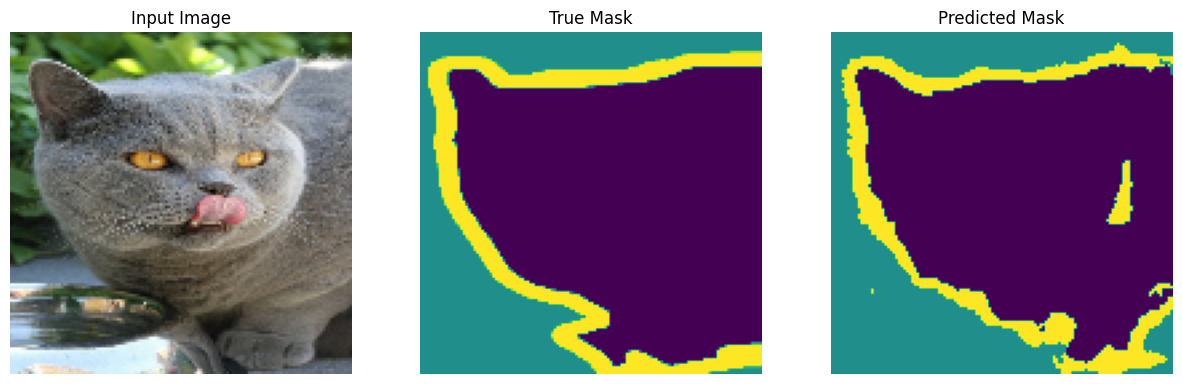

2/2 [==============================] - 2s 1s/step


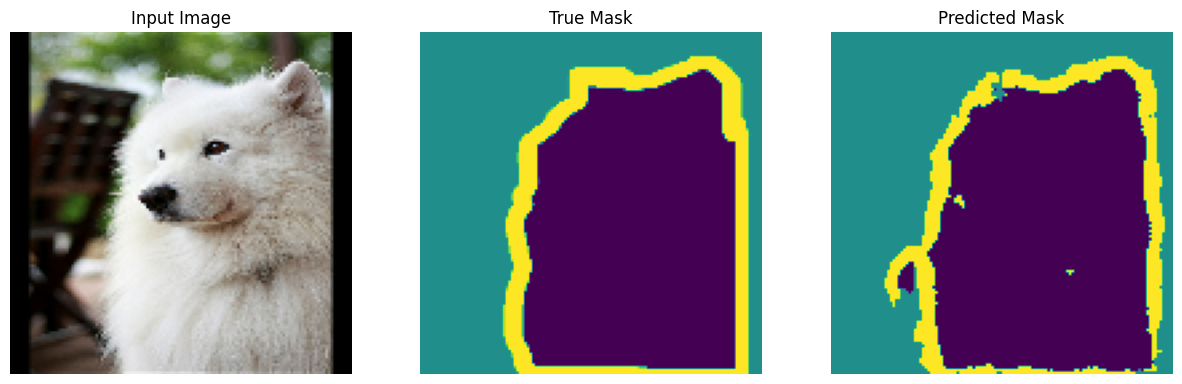

In [ ]:
show_predictions(validation_dataset, 3)

Next we will use CNN-model to deal with the dataset and see the performance.

In [17]:
import os
import glob
import datetime
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization

In [ ]:
model3 = Sequential([
    Conv2D(32, 5, padding = 'same', input_shape = (128, 128, 3)),
    Conv2D(32, 5, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(32, 4, padding = 'same'),
    Conv2D(32, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(64, 4, padding = 'same'),
    Conv2D(64, 4, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    BatchNormalization(),
    Conv2D(64, 3, padding = 'same'),
    Conv2D(64, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(128, 3, padding = 'same'),
    Conv2D(128, 3, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),
    Conv2D(128, 2, padding = 'same'),
    Conv2D(128, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Conv2D(256, 2, padding = 'same'),
    Conv2D(256, 2, padding = 'same', activation = LeakyReLU(alpha = 0.5)),
    MaxPooling2D(),

    Flatten(),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation = 'sigmoid'),
    Dropout(0.2),
    Dense(256, activation = 'sigmoid'),
    Dropout(0.1),
    Dense(len(labelEncDict), activation = 'softmax')
    tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128
])

model.compile(optimizer = Adam(LEARNING_RATE),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

model.summary()